## Oriented FAST and Rotated BRIEF (ORB)

One of the most challenging problems in computer vision is object detection. Object detection is the ability to recognize particular objects in images and being able to determine the location of those objects within the images. For example, if we perform car detection in the image below, we will not only be interested in saying how many cars are there in the image but also *where* those cars are in the image.
<br>
<figure>
  <img src = "./in_cell_images/cars_road.jpg" width = 80% style = "border: thin silver solid; padding: 10px">
      <figcaption style = "text-align: center; font-style: italic">Fig1. - Car Detection.</figcaption>
</figure> 
<br>
In order to perform this object-based image analysis, we will use ORB. ORB is a very fast algorithm that creates feature vectors from detected keypoints. You've learned that ORB has some great properties, such as being invariant to rotations, changes in illumination, and noise. 

In this notebook, we will see these properties in action and implement the ORB algorithm to detect a person’s face in an image using facial keypoints.  

### Loading Images and Importing Resources

In the code below we will use OpenCV to load an image of a woman’s face, which will use as our training image. Since, the `cv2.imread()` function loads images as BGR we will convert our image to RGB so we can display it with the correct colors. As usual we will convert our BGR image to Gray scale for analysis.

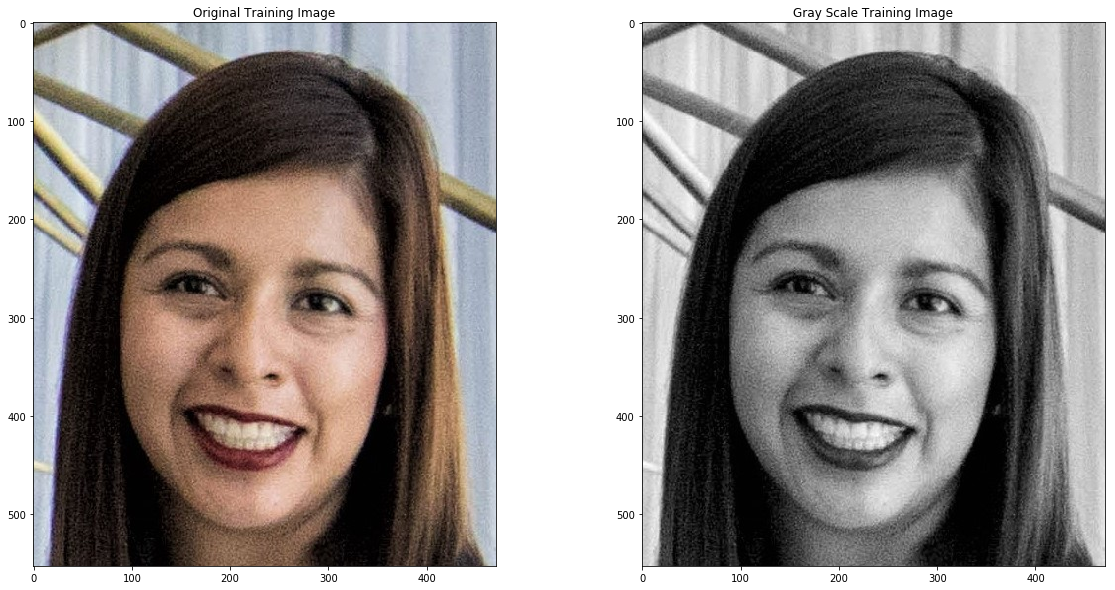

In [1]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt

# Set the default figure size
plt.rcParams['figure.figsize'] = [20,10]

# Load the training image
image = cv2.imread('images/face.jpeg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the training image to gray Scale
training_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display the images
plt.subplot(121)
plt.title('Original Training Image')
plt.imshow(training_image)
plt.subplot(122)
plt.title('Gray Scale Training Image')
plt.imshow(training_gray, cmap = 'gray')
plt.show()

## Locating Keypoints

The first step in the ORB algorithm is to locate all the keypoints in the training image. After the keypoints have been located, ORB creates their corresponding binary feature vectors and groups them together in the ORB descriptor.

We will use OpenCV’s `ORB` class to locate the keypoints and create their corresponding ORB descriptor. The parameters of the ORB algorithm are setup using the `ORB_create()` function. The parameters of the `ORB_create()` function and their default values are given below:


`cv2.ORB_create(nfeatures = 500,
               scaleFactor = 1.2,
		       nlevels = 8,
		       edgeThreshold = 31,
		       firstLevel = 0,
		       WTA_K = 2,
		       scoreType = HARRIS_SCORE,
		       patchSize = 31,
		       fastThreshold = 20)`
    
Parameters:

* **nfeatures** - *int*  
Determines the maximum number of features (keypoints) to locate.


* **scaleFactor** - *float*  
Pyramid decimation ratio, must be greater than 1. ORB uses an image pyramid to find features, therefore you must provide the scale factor between each layer in the pyramid and the number of levels the pyramid has. A `scaleFactor = 2` means the classical pyramid, where each next level has 4x less pixels than the previous. A big scale factor will diminish the number of features found.


* **nlevels** - *int*  
The number of pyramid levels. The smallest level will have a linear size equal to input_image_linear_size/pow(scaleFactor, nlevels).


* **edgeThreshold** - - *int*  
The size of the border where features are not detected. Since the keypoints have a specific pixel size, the edges of images must be excluded from the search. The size of the `edgeThreshold` should be equal to or greater than the patchSize parameter.


* **firstLevel** - *int*  
This parameter allows you to determine which level should be treated as the first level in the pyramid. It should be 0 in the current implementation. Usually, the pyramid level with a scale of unity is considered the first level.


* **WTA_K** - *int*  
The number of random pixels used to produce each element of the oriented BRIEF descriptor. The possible values are 2, 3, and 4, with 2 being the default value. For example, a value of 3 means three random pixels are chosen at a time to compare their brightness. The index of the brightest pixel is returned. Since there are 3 pixels, the returned index will be either 0, 1, or 2.


* **scoreType** - *int*  
This parameter can be set to either HARRIS_SCORE or FAST_SCORE. The default HARRIS_SCORE means that the Harris corner algorithm is used to rank features. The score is used to only retain the best features. The FAST_SCORE produces slightly less stable keypoints, but it is a little faster to compute.


* **patchSize** - *int*  
Size of the patch used by the oriented BRIEF descriptor. Of course, on smaller pyramid layers the perceived image area covered by a feature will be larger.


As we can see, the `cv2. ORB_create()`function supports a wide range of parameters. The first two arguments (`nfeatures` and ` scaleFactor`) are probably the ones you are most likely to change. The other parameters can be safely left at their default values and you will get good results.

In the code below, we will use the `ORB_create()`function to set the maximum number of keypoints we want to detect to 200, and to set the pyramid decimation ratio to 2.1. We will then use the ` .detectAndCompute (image)`method to locate the keypoints in the given training `image`and to compute their corresponding ORB descriptor.  Finally, we will use the ` cv2.drawKeypoints()`function to visualize the keypoints found by the ORB algorithm.  

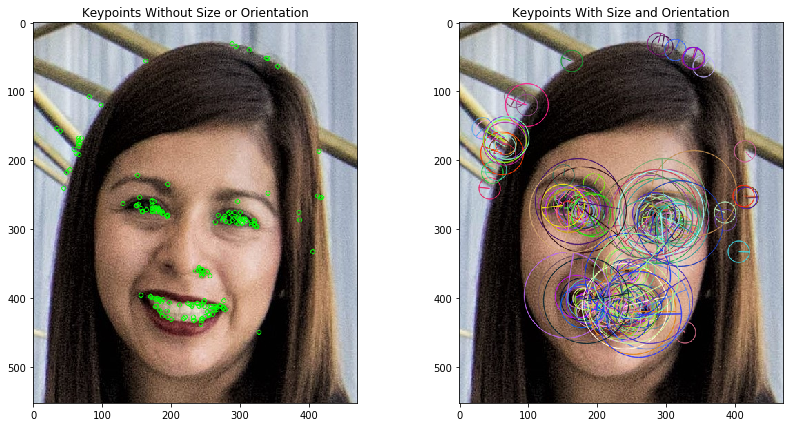


Number of keypoints Detected:  175


In [2]:
# Import copy to make copies of the training image
import copy

# Set the default figure size
plt.rcParams['figure.figsize'] = [14.0, 7.0]

# Set the parameters of the ORB algorithm by specifying the maximum number of keypoints to locate and
# the pyramid decimation ratio
orb = cv2.ORB_create(200, 2.0)

# Find the keypoints in the gray scale training image and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask.
keypoints, descriptor = orb.detectAndCompute(training_gray, None)

# Create copies of the training image to draw our keypoints on
keyp_without_size = copy.copy(training_image)
keyp_with_size = copy.copy(training_image)

# Draw the keypoints without size or orientation on one copy of the training image 
cv2.drawKeypoints(training_image, keypoints, keyp_without_size, color = (0, 255, 0))

# Draw the keypoints with size and orientation on the other copy of the training image
cv2.drawKeypoints(training_image, keypoints, keyp_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image with the keypoints without size or orientation
plt.subplot(121)
plt.title('Keypoints Without Size or Orientation')
plt.imshow(keyp_without_size)

# Display the image with the keypoints with size and orientation
plt.subplot(122)
plt.title('Keypoints With Size and Orientation')
plt.imshow(keyp_with_size)
plt.show()

# Print the number of keypoints detected
print("\nNumber of keypoints Detected: ", len(keypoints))

As we can see in the right image, every keypoint has a center, a size, and an angle. The center determines the location of each keypoint in the image; the size of each keypoint is determined by the patch size used by BRIEF to create its feature vector; and the angle tells us the orientation of the keypoint as determined by rBRIEF.

Once the keypoints for the training image have been found and their corresponding ORB descriptor has been calculated, the same thing can be done for the query image. In order to see the properties of the ORB algorithm more clearly, in the next sections we will use the same image as our training and query image.   

# Feature Matching

Once we have the ORB descriptors for *both* the training and query images, the final step is to perform keypoint matching between the two images using their corresponding ORB descriptors. This *matching* is usually performed by a matching function. One of the most commonly used matching functions is called *Brute-Force*.

In the code below we will use OpenCV’s `BFMatcher ` class to compare the keypoints in the training and query images.. The parameters of the Brute-Force matcher are setup using the `cv2.BFMatcher()`function. The parameters of the `cv2.BFMatcher()`function and their default values are given below:



`cv2.BFMatcher(normType = cv2.NORM_L2,
		 	  crossCheck = false)`

Parameters:

* **normType**  
Specifies the metric used to determine the quality of the match. By default, `normType = cv2.NORM_L2`, which measures the distance between two descriptors.  However, for binary descriptors like the ones created by ORB, the Hamming metric is more suitable. The Hamming metric determines the distance by counting the number of dissimilar bits between the binary descriptors. When the ORB descriptor is created using `WTA_K = 2`, two random pixels are chosen and compared in brightness. The index of the brightest pixel is returned as either 0 or 1.  Such output only occupies 1 bit, and therefore the ` cv2.NORM_HAMMING` metric should be used.  If, on the other hand, the ORB descriptor is created using `WTA_K = 3`, three random pixels are chosen and compared in brightness. The index of the brightest pixel is returned as either 0, 1, or 2.  Such output will occupy 2 bits, and therefore a special variant of the Hamming distance, known as the `cv2.NORM_HAMMING2` (the 2 stands for 2 bits), should be used instead. Then, for any metric chosen, when comparing the keypoints in the training and query images, the pair with the smaller metric (distance between them) is considered the best match.


* **crossCheck** - *bool* 
A Boolean variable and can be set to either `True` or `False`. Cross-checking is very useful for eliminating false matches. Cross-checking works by performing the matching procedure two times. The first time the keypoints in the training image are compared to those in the query image; the second time, however, the keypoints in the query image are compared to those in the training image (*i.e.* the comparison is done backwards). When cross-checking is enabled a match is considered valid only if keypoint *A* in the training image is the best match of keypoint *B* in the query image and vice-versa (that is, if keypoint *B* in the query image is the best match of point *A* in the training image). 

Once the parameters of the *BFMatcher* have been set, we can use the `.match(descriptors_train, descriptors_query)` method to find the matching  keypoints between the training and query images using their ORB descriptors. Finally, we will use the ` cv2.drawMatches ()` function to visualize the matching keypoints found by the Brute-Force matcher. This function stacks the training and query images horizontally and draws lines from the keypoints in the training image to their corresponding best matching keypoints in the query image. Remember that in order to see the properties of the ORB algorithm more clearly, in the following examples we will use the same image as our training and query image.    

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Set the default figure size
plt.rcParams['figure.figsize'] = [14.0, 7.0]

# Load the training image
image1 = cv2.imread('./images/face.jpeg')

# Load the query image
image2 = cv2.imread('./images/face.jpeg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the query image to RGB
query_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display the training and query images
plt.subplot(121)
plt.title('Training Image')
plt.imshow(training_image)
plt.subplot(122)
plt.title('Query Image')
plt.imshow(query_image)
plt.show()

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)

# Convert the query image to gray scale
query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)

# Set the parameters of the ORB algorithm by specifying the maximum number of keypoints to locate and
# the pyramid decimation ratio
orb = cv2.ORB_create(1000, 2.0)

# Find the keypoints in the gray scale training and query images and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask in either case.
keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_gray, None)

# Create a Brute Force Matcher object. Set crossCheck to True so that the BFMatcher will only return consistent
# pairs. Such technique usually produces best results with minimal number of outliers when there are enough matches.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the query image
matches = bf.match(descriptors_train, descriptors_query)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
matches = sorted(matches, key = lambda x : x.distance)

# Connect the keypoints in the training image with their best matching keypoints in the query image.
# The best matches correspond to the first elements in the sorted matches list, since they are the ones
# with the shorter distance. We draw the first 300 mathces and use flags = 2 to plot the matching keypoints
# without size or orientation.
result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:300], query_gray, flags = 2)

# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(keypoints_query))

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

In the above example, since both the training and query images are the exactly the same, we expect that the same number of keypoints are found in both images, and that all the keypoints match. We can clearly see that this indeed the case, ORB has found the same number of keypoints in both images and the Brute-Force matcher has been able to correctly match all the keypoints in training and query images.

# ORB's Main Properties

We will now explore each of the main properties of the ORB algorithm:

* Scale Invariance
* Rotational Invariance
* Illumination Invariance
* Noise Invariance

Again, in order to see the properties of the ORB algorithm more clearly, in the following examples we will use the same image as our training and query image. 


## Scale Invariance

The ORB algorithm is scale invariant. This means that it is able to detect objects in images regardless of their size. To see this, we will now use our Brute-Force matcher to match points between the training image and a query image that is a ¼ the size of the original training image. 

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Set the default figure size
plt.rcParams['figure.figsize'] = [14.0, 7.0]

# Load the training image
image1 = cv2.imread('./images/face.jpeg')

# Load the query image
image2 = cv2.imread('./images/faceQS.png')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the query image to RGB
query_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display the images
plt.subplot(121)
plt.title('Training Image')
plt.imshow(training_image)
plt.subplot(122)
plt.title('Query Image')
plt.imshow(query_image)
plt.show()

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)

# Convert the query image to gray scale
query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)

# Set the parameters of the ORB algorithm by specifying the maximum number of keypoints to locate and
# the pyramid decimation ratio
orb = cv2.ORB_create(1000, 2.0)

# Find the keypoints in the gray scale training and query images and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask in either case.
keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_gray, None)

# Create a Brute Force Matcher object. Set crossCheck to True so that the BFMatcher will only return consistent
# pairs. Such technique usually produces best results with minimal number of outliers when there are enough matches.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the query image
matches = bf.match(descriptors_train, descriptors_query)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
matches = sorted(matches, key = lambda x : x.distance)

# Connect the keypoints in the training image with their best matching keypoints in the query image.
# The best matches correspond to the first elements in the sorted matches list, since they are the ones
# with the shorter distance. We draw the first 30 mathces and use flags = 2 to plot the matching keypoints
# without size or orientation.
result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:30], query_gray, flags = 2)

# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print the shape of the training image
print('\nThe Training Image has shape:', training_gray.shape)

#Print the shape of the query image
print('The Query Image has shape:', query_gray.shape)

# Print the number of keypoints detected in the training image
print("\nNumber of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(keypoints_query))

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

In the above example, notice that the training image is 553 x 471 pixels, while the query image is 138 x 117 pixels,  ¼ the size of the original training image. Also notice that the number of keypoints detected in the query image is only 65, much smaller than the 831 keypoints found in the training image. Nevertheless, we can see that our Brute-Force matcher can match most of the keypoints in the query image with their corresponding keypoints in the training image.

## Rotational Invariance

The ORB algorithm is also rotationally invariant. This means that it is able to detect objects in images regardless of their orientation. To see this, we will now use our Brute-Force matcher to match points between the training image and a query image that has been rotated by 90 degrees. 

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Set the default figure size
plt.rcParams['figure.figsize'] = [14.0, 7.0]

# Load the training image
image1 = cv2.imread('./images/face.jpeg')

# Load the query image
image2 = cv2.imread('./images/faceR.jpeg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the query image to RGB
query_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display the images
plt.subplot(121)
plt.title('Training Image')
plt.imshow(training_image)
plt.subplot(122)
plt.title('Query Image')
plt.imshow(query_image)
plt.show()

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)

# Convert the query image to gray scale
query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)

# Set the parameters of the ORB algorithm by specifying the maximum number of keypoints to locate and
# the pyramid decimation ratio
orb = cv2.ORB_create(1000, 2.0)

# Find the keypoints in the gray scale training and query images and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask in either case.
keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_gray, None)

# Create a Brute Force Matcher object. Set crossCheck to True so that the BFMatcher will only return consistent
# pairs. Such technique usually produces best results with minimal number of outliers when there are enough matches.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the query image
matches = bf.match(descriptors_train, descriptors_query)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
matches = sorted(matches, key = lambda x : x.distance)

# Connect the keypoints in the training image with their best matching keypoints in the query image.
# The best matches correspond to the first elements in the sorted matches list, since they are the ones
# with the shorter distance. We draw the first 100 mathces and use flags = 2 to plot the matching keypoints
# without size or orientation.
result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:100], query_gray, flags = 2)

# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print the number of keypoints detected in the training image
print("\nNumber of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(keypoints_query))

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

In the above example, we see that the number of keypoints detected in both images is very similar, and that even though the query image is rotated, our Brute-Force matcher can still match about 78% of the keypoints found. Also, notice that most of the matching keypoints are close to particular facial features, such as the eyes, nose, and mouth.   

## Illumination Invariance

The ORB algorithm is also illumination invariant. This means that it is able to detect objects in images regardless of their illumination. To see this, we will now use our Brute-Force matcher to match points between the training image and a query image that is much brighter.

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Set the default figure size
plt.rcParams['figure.figsize'] = [14.0, 7.0]

# Load the training image
image1 = cv2.imread('./images/face.jpeg')

# Load the query image
image2 = cv2.imread('./images/faceRI.png')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the query image to RGB
query_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display the images
plt.subplot(121)
plt.title('Training Image')
plt.imshow(training_image)
plt.subplot(122)
plt.title('Query Image')
plt.imshow(query_image)
plt.show()

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)

# Convert the query image to gray scale
query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)

# Set the parameters of the ORB algorithm by specifying the maximum number of keypoints to locate and
# the pyramid decimation ratio
orb = cv2.ORB_create(1000, 2.0)

# Find the keypoints in the gray scale training and query images and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask in either case.
keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_gray, None)

# Create a Brute Force Matcher object. Set crossCheck to True so that the BFMatcher will only return consistent
# pairs. Such technique usually produces best results with minimal number of outliers when there are enough matches.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the query image
matches = bf.match(descriptors_train, descriptors_query)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
matches = sorted(matches, key = lambda x : x.distance)

# Connect the keypoints in the training image with their best matching keypoints in the query image.
# The best matches correspond to the first elements in the sorted matches list, since they are the ones
# with the shorter distance. We draw the first 100 mathces and use flags = 2 to plot the matching keypoints
# without size or orientation.
result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:100], query_gray, flags = 2)

# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print the number of keypoints detected in the training image
print("\nNumber of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(keypoints_query))

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

In the above example, we see that the number of keypoints detected in both images is again very similar, and that even though the query image is much brighter, our Brute-Force matcher can still match about 63% of the keypoints found. 

## Noise Invariance

The ORB algorithm is also noise invariant. This means that it is able to detect objects in images, even if the images have some degree of noise. To see this, we will now use our Brute-Force matcher to match points between the training image and a query image that has a lot of noise.

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Set the default figure size
plt.rcParams['figure.figsize'] = [14.0, 7.0]

# Load the training image
image1 = cv2.imread('./images/face.jpeg')

# Load the noisy, gray scale query image. 
image2 = cv2.imread('./images/faceRN5.png')

# Convert the query image to gray scale
query_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

# Display the images
plt.subplot(121)
plt.imshow(training_gray, cmap = 'gray')
plt.title('Gray Scale Training Image')
plt.subplot(122)
plt.imshow(query_gray, cmap = 'gray')
plt.title('Query Image')
plt.show()

# Set the parameters of the ORB algorithm by specifying the maximum number of keypoints to locate and
# the pyramid decimation ratio
orb = cv2.ORB_create(1000, 1.3)

# Find the keypoints in the gray scale training and query images and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask in either case. 
keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_gray, None)

# Create a Brute Force Matcher object. We set crossCheck to True so that the BFMatcher will only return consistent
# pairs. Such technique usually produces best results with minimal number of outliers when there are enough matches.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the query image
matches = bf.match(descriptors_train, descriptors_query)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
matches = sorted(matches, key = lambda x : x.distance)

# Connect the keypoints in the training image with their best matching keypoints in the query image.
# The best matches correspond to the first elements in the sorted matches list, since they are the ones
# with the shorter distance. We draw the first 100 mathces and use flags = 2 to plot the matching keypoints
# without size or orientation.
result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:100], query_gray, flags = 2)

# we display the image
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(keypoints_query))

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

In the above example, again we see that the number of keypoints detected in both images is very similar, and that even though the query image is has a lot of noise, our Brute-Force matcher can still match about 63% of the keypoints found.  Also, notice that most of the matching keypoints are close to particular facial features, such as the eyes, nose, and mouth. In addition, we can see that there are a few features that don’t quite match up, but may have been chosen because of similar patterns of intensity in that area of the image.  We will also like to point out that in this case we used a pyramid decimation ratio of 1.3, instead of the of value of 2.0 we used in the previous examples, because in this particular case, it produces better results. 


# Object Detection

We will now implement the ORB algorithm to detect the face in the training image in another image. As usual, we will start by loading our training and query images.

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Set the default figure size
plt.rcParams['figure.figsize'] = [14.0, 7.0]

# Load the training image
image1 = cv2.imread('./images/face.jpeg')

# Load the query image
image2 = cv2.imread('./images/Team.jpeg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the query image to RGB
query_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display the images
plt.subplot(121)
plt.imshow(training_image)
plt.title('Training Image')
plt.subplot(122)
plt.imshow(query_image)
plt.title('Query Image')
plt.show()

In this particular case, the training image contains a face, therefore, as we have seen, the majority of the keypoints detected are close to facial features, such as the eyes, nose, and mouth. On the other hand, our query image is a picture of a group of people, one of which, is the woman we want to detect.  Let’s now detect the keypoints for the query image. 

In [ ]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [34.0, 34.0]

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)

# Convert the query image to gray scale
query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)

# Set the parameters of the ORB algorithm by specifying the maximum number of keypoints to locate and
# the pyramid decimation ratio
orb = cv2.ORB_create(5000, 2.0)

# Find the keypoints in the gray scale training and query images and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask in either case.  
keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_gray, None)

# Create copies of the query images to draw our keypoints on
query_img_keyp = copy.copy(query_image)

# Draw the keypoints with size and orientation on the copy of the query image
cv2.drawKeypoints(query_image, keypoints_query, query_img_keyp, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the query image with the keypoints with size and orientation
plt.title('Keypoints With Size and Orientation', fontsize = 30)
plt.imshow(query_img_keyp)
plt.show()

# Print the number of keypoints detected
print("\nNumber of keypoints Detected: ", len(keypoints_query))

We can see that the query image has keypoints in many parts of the image. Now that we have the keypoints and ORB descriptors of both the training  and query images, we can use a Brute-Force matcher to try to locate the woman’s face in the query image. 

In [ ]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [34.0, 34.0]

# Create a Brute Force Matcher object. We set crossCheck to True so that the BFMatcher will only return consistent
# pairs. Such technique usually produces best results with minimal number of outliers when there are enough matches.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the query image
matches = bf.match(descriptors_train, descriptors_query)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
matches = sorted(matches, key = lambda x : x.distance)

# Connect the keypoints in the training image with their best matching keypoints in the query image.
# The best matches correspond to the first elements in the sorted matches list, since they are the ones
# with the shorter distance. We draw the first 85 mathces and use flags = 2 to plot the matching keypoints
# without size or orientation.
result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:85], query_gray, flags = 2)

# we display the image
plt.title('Best Matching Points', fontsize = 30)
plt.imshow(result)
plt.show()

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(keypoints_query))

# Print total number of matching Keypoints between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

We can clearly see that even though there are many faces and objects in the query image, our Brute-Force matcher has been able to correctly locate the woman’s face in the query image.